# Setup

In [ ]:
# 구글 드라이브를 코랩과 연결하는 코드입니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 현재 경로를 지정하는 코드입니다.
%cd '/content/drive/MyDrive/iNThon'

/content/drive/MyDrive/iNThon


In [ ]:
# 베이스라인 코드를 실행하기 위하여 필요한 라이브러리를 설치하는 코드입니다.
!pip install fastapi kaleido python-multipart uvicorn
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib jsonlines rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.
  Installing build depe

jsonl 형식의 데이터셋을 불러오는 코드입니다.

    {
      "id": 1,
      "type": "Type 2",
      "size": 6,
      "set": "또#이상#준다#핀잔#사#티셔츠",
      "sentence": "또 이상한 티셔츠를 사서 핀잔을 준다."
    },
    {
      "id": 2,
      "type": "Type 1",
      "size": 6,
      "set": "탄다#해변#썰물 때#말#사람#세",
      "sentence": "썰물 때에 세명의 사람들이 해변에서 말을 탄다."
    },
    ...

데이터의 형태는 위와 같습니다. 가장 간단하게 `"set"`을 입력으로, `"sentence"`를 출력으로 사용할 것입니다. 이후 훈련 집합을 `train.jsonl`에 저장하였습니다.
또한 위에서 `"sentence"`가 빠진 형태인 평가 집합을 `eval.jsonl`에 저장하였습니다.

다른 변수들도 학습에 도움이 될 것이라고 판단하신다면 자유롭게 수정하셔도 좋습니다. 여러분의 아이디어를 보여 주세요!

In [ ]:
# 데이터셋을 위의 설명대로 변환하는 코드입니다.
import jsonlines
import json

input_file_path = 'train.json'
train_file_path = 'train.jsonl'

with open(input_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

with jsonlines.open(train_file_path, mode='w') as writer:
    for item in data['dataset']:
        writer.write({"input": item["set"], "output": item["sentence"]})

input_file_path = 'test.json'
eval_file_path = 'eval.jsonl'

with open(input_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

with jsonlines.open(eval_file_path, mode='w') as writer:
    for item in data['dataset']:
        writer.write({"input": item["set"]})

(train_file_path, eval_file_path)

('train.jsonl', 'eval.jsonl')

In [ ]:
# 데이터셋을 불러오는 코드입니다.
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='eval.jsonl', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Load Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "nlpai-lab/kullm-polyglot-5.8b-v2"
model = AutoModelForCausalLM.from_pretrained(base_model_id)

config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/748M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

# Tokenizer

In [ ]:
# 패딩을 포함한 토크나이저를 설정하고 적용하는 코드입니다.
max_length = 115

def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

In [ ]:
# 토크나이저를 설정하는 코드입니다.
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def formatting_func(example):
    text = f"{example['input']}"
    return text

def generate_and_tokenize_text(text):
    return tokenizer(formatting_func(text))

tokenizer_config.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
# 데이터셋에 있는 각각의 데이터를 토큰화하는 코드입니다.
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_text)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_text)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

31500


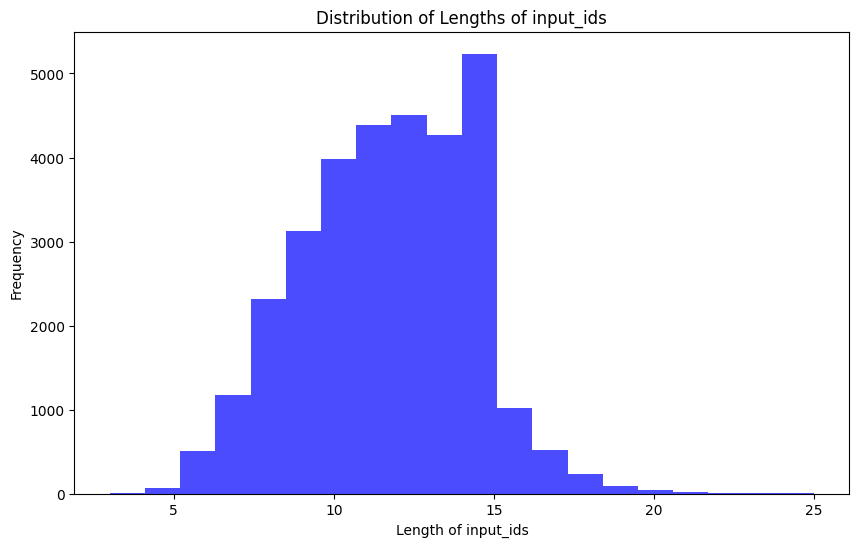

In [ ]:
# 데이터 길이 분포를 시각화하는 코드입니다.
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
# 패딩을 포함한 토크나이저를 설정하고 적용하는 코드입니다.
max_length = 128

def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
# 훈련 가능한 파라미터의 수를 계산해 주는 함수입니다.
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(model)

# Inference

In [ ]:
template = """아래는 작업을 설명하는 명령어와 추가 컨텍스트를 제공하는 입력이 짝을 이루는 예제입니다. 요청을 적절히 완료하는 응답을 작성하세요.

### 명령어:
{instruction}

### 입력:
{input}

### 응답:
"""

In [ ]:
import jsonlines
from tqdm import tqdm
import warnings
from transformers import pipeline

with jsonlines.open('train.jsonl') as reader, jsonlines.open('predictions.jsonl', mode='w') as writer:
    for eval_entry in tqdm(reader, total=len(eval_dataset)):
        eval_input = eval_entry['input']
        eval_output = eval_entry['output']

        eval_prompt = f"{eval_input}"

        # = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
        #del model_input['token_type_ids']
        
        model.to('cuda')
        model.eval()

        pipe = pipeline("text-generation", model=model, tokenizer = "nlpai-lab/kullm-polyglot-5.8b-v2", device='cuda')

        with torch.no_grad():
            prompt = template.format(instruction = "단어들은 , 기호로 구분되어 있으며, 출력 문장에는 모든 단어가 필수적으로 포함된 자연스러운 문장을 만들어주세요.", input = eval_prompt)
            output = pipe(prompt, max_length = 128, temperature = 0.5, num_beams=5, pad_token_id=tokenizer.eos_token_id, eos_token_id = tokenizer.eos_token_id)
            
            #answer = prompter.get_response(s)
            #output = model.generate(**model_input, max_new_tokens=32, pad_token_id=tokenizer.eos_token_id)
            print("입력 : {} \n 정답 : {} \n 예측 : {} \n".format(eval_prompt, eval_output ,output[0]['generated_text'].split("### 응답:\n")[1]))
            answer = output[0]['generated_text'].split("### 응답:\n")[1])
            #answer = tokenizer.decode(output[0], skip_special_tokens=True)

        writer.write({"input": eval_input, "output": answer})

print("Predictions have been written to predictions.jsonl")

    predictions.append(''.join(pred["output"].split(pred["input"])[1:]))

`predictions_baseline_trained.jsonl` 파일에 있는 각 행의 "output"이라는 키의 구조는 다음과 같습니다.

`"output" = "input"에 해당하는 주어진 텍스트 + 새롭게 만들어낸 텍스트`

하지만 위 코드에서 볼 수 있는 것과 같이 **"input"에 해당하는 주어진 텍스트의 다음 텍스트**, 즉 새롭게 만들어낸 텍스트부터 채점에 포함할 예정입니다.

In [ ]:
# 생성된 텍스트를 평가하는 코드입니다.
from rouge import Rouge
from bert_score import score

predictions_file = 'predictions_baseline_trained.jsonl'
eval_file = 'train.jsonl'

predictions = []
references = []
with jsonlines.open(predictions_file) as pred_reader, jsonlines.open(eval_file) as eval_reader:
    for i, (pred, eval) in enumerate(zip(pred_reader, eval_reader)):
        if i >= 100:
            break
        predictions.append(''.join(pred["output"].split(pred["input"])[1:]))
        references.append(eval["output"])

rouge = Rouge()
rouge_scores = rouge.get_scores(predictions, references, avg=True)

P, R, F1 = score(predictions, references, lang="ko", model_type="bert-base-multilingual-cased")
bertscore = F1.mean()

print("ROUGE-1:", round(rouge_scores['rouge-1']['f'], 4))
print("ROUGE-2:", round(rouge_scores['rouge-2']['f'], 4))
print("ROUGE-L:", round(rouge_scores['rouge-l']['f'], 4))
print("BERTScore:", round(bertscore.item(), 4))

print()
print("Final Score:", round(0.1 * rouge_scores['rouge-1']['f'] + 0.1 * rouge_scores['rouge-2']['f'] +
                            0.2 * rouge_scores['rouge-l']['f'] + 0.6 * bertscore.item(), 4))

# 8. 결과 제출
세 개의 파일(`test.json`, `eval.jsonl`, `predictions_baseline_trained.jsonl`)을 사용하여 특정 데이터를 추출하고 이를 판다스 데이터프레임으로 변환합니다.

1. **JSON 파일 로드**: `test.json` 파일을 열어 JSON 데이터를 파싱합니다.

2. **eval.jsonl 파일 처리**: `eval.jsonl` 파일을 열어 각 항목의 `"input"` 키에 해당하는 값을 키로 하여 딕셔너리(`eval_data`)를 구성합니다.

3. **predictions_baseline_trained.jsonl 파일 처리**: `predictions_baseline_trained.jsonl` 파일을 열어 각 항목에서 모델이 새롭게 만들어낸 텍스트를 추출하여, 해당 `"input"` 키에 대응하는 값으로 딕셔너리(`predictions_data`)를 구성합니다.

4. **데이터프레임 생성**: 각 `set`의 `id`와 `eval.jsonl` 파일의 `"input"`이 일치하는 경우, 이에 해당하는 `predictions_baseline_trained.jsonl` 파일의 텍스트를 찾아 데이터프레임에 추가합니다. 결과적으로, 각 행은 `id`와 관련된 텍스트(`sentence`)로 구성됩니다.

최종적으로 이 코드는 세 파일 간의 관계를 매핑하여, 각 `id`에 대응하는 예측된 텍스트를 포함하는 데이터프레임을 생성합니다.

Kaggle에 최종적으로 제출해야 하는 양식은 다음과 같습니다.

|    id    |  sentence  |
|----------|------------|
| 30001    | 답안 1     |
| 30002    | ​​​​​​​​​​​​​​​​​​​​​​답안 2     |
| 30003    | 답안 3     |
| 30004    | 답안 4     |
| 30005    | 답안 5     |
| ...      | ...        |
| 31496    | 답안 1496  |
| 31497    | 답안 1497  |
| 31498    | 답안 1498  |
| 31499    | 답안 1499  |
| 31500    | 답안 1500  |


형식에 주의하여 모델의 성능보다 떨어지는 점수를 얻는 일이 없도록 합시다!

In [ ]:
# json, jsonl 파일을 처리하여 제출에 필요한 데이터들을 골라내는 코드입니다.
import json
import pandas as pd

json_file_path = 'train.json' # 'test.json'
eval_file_path = 'train.jsonl' # 'eval.jsonl'
predictions_file_path = 'predictions_baseline_trained.jsonl'

with open(json_file_path, 'r', encoding='utf-8') as file:
    json_data = json.load(file)

eval_data = {}
with jsonlines.open(eval_file_path) as reader:
    for entry in reader:
        eval_data[entry['input']] = entry

predictions_data = {}
with jsonlines.open(predictions_file_path) as reader:
    for entry in reader:
        text_after_keyword = ''.join(entry['output'].split(entry['input'])[1:])
        predictions_data[entry['input']] = text_after_keyword

In [ ]:
# 제출 파일의 형식에 맞는 데이터프레임을 생성하는 코드입니다.
df_data = []
for i, data in enumerate(json_data['dataset']):
    if i >= 100:
        break # 제출을 위해 데이터프레임을 생성할 때는 삭제해야 합니다.

    if data['set'] in eval_data:
        id = data['id']
        sentence = predictions_data.get(eval_data[data['set']]['input'], "")
        df_data.append([id, sentence])

df = pd.DataFrame(df_data, columns=['id', 'sentence'])
df

In [ ]:
# 제출 파일을 로컬이나 구글 드라이브에 저장하는 코드입니다.
df.to_csv('submit.csv', index=False, encoding='utf-8')